In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from HybridAStar.hybrid_a_star import *

import os
import imageio.v2 as imageio
import pickle

# Density estimation

In [16]:
ROOM_NUM = 1

with open(f'room_points_{ROOM_NUM}.npy', 'rb') as f:
    room_latent = np.load(f)

print(room_latent.shape)

room_pos = room_latent[:,:2]
print(room_pos.shape)

(10000, 4)
(10000, 2)


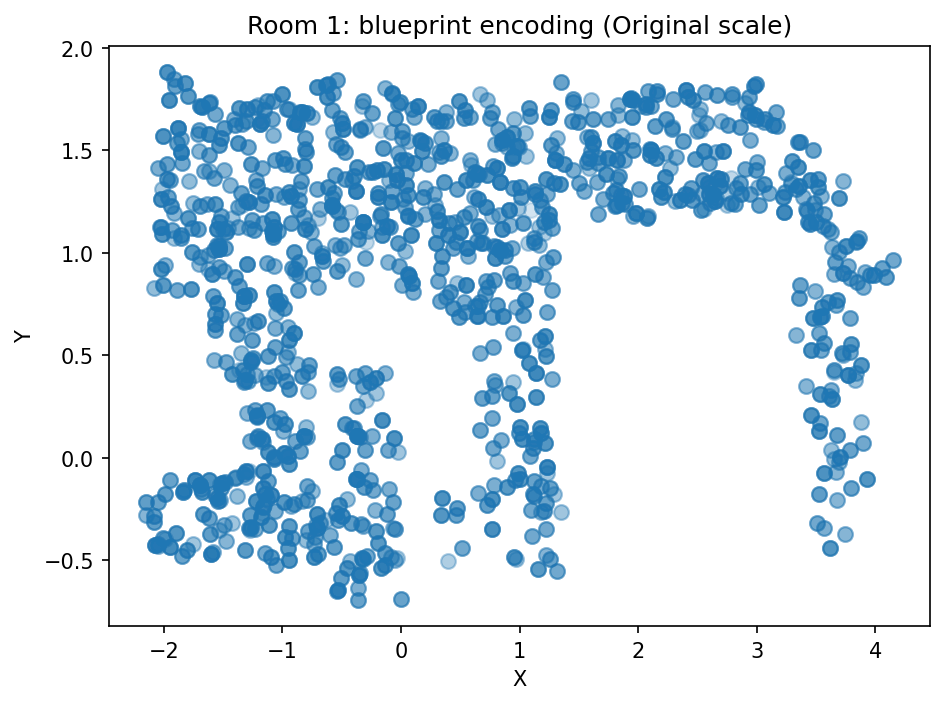

In [17]:
_ = plt.figure(dpi=150)
plt.scatter(room_pos[:,0], room_pos[:,1], color="tab:blue", s=50, alpha=.1)
plt.title(f"Room {ROOM_NUM}: blueprint encoding (Original scale)")
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

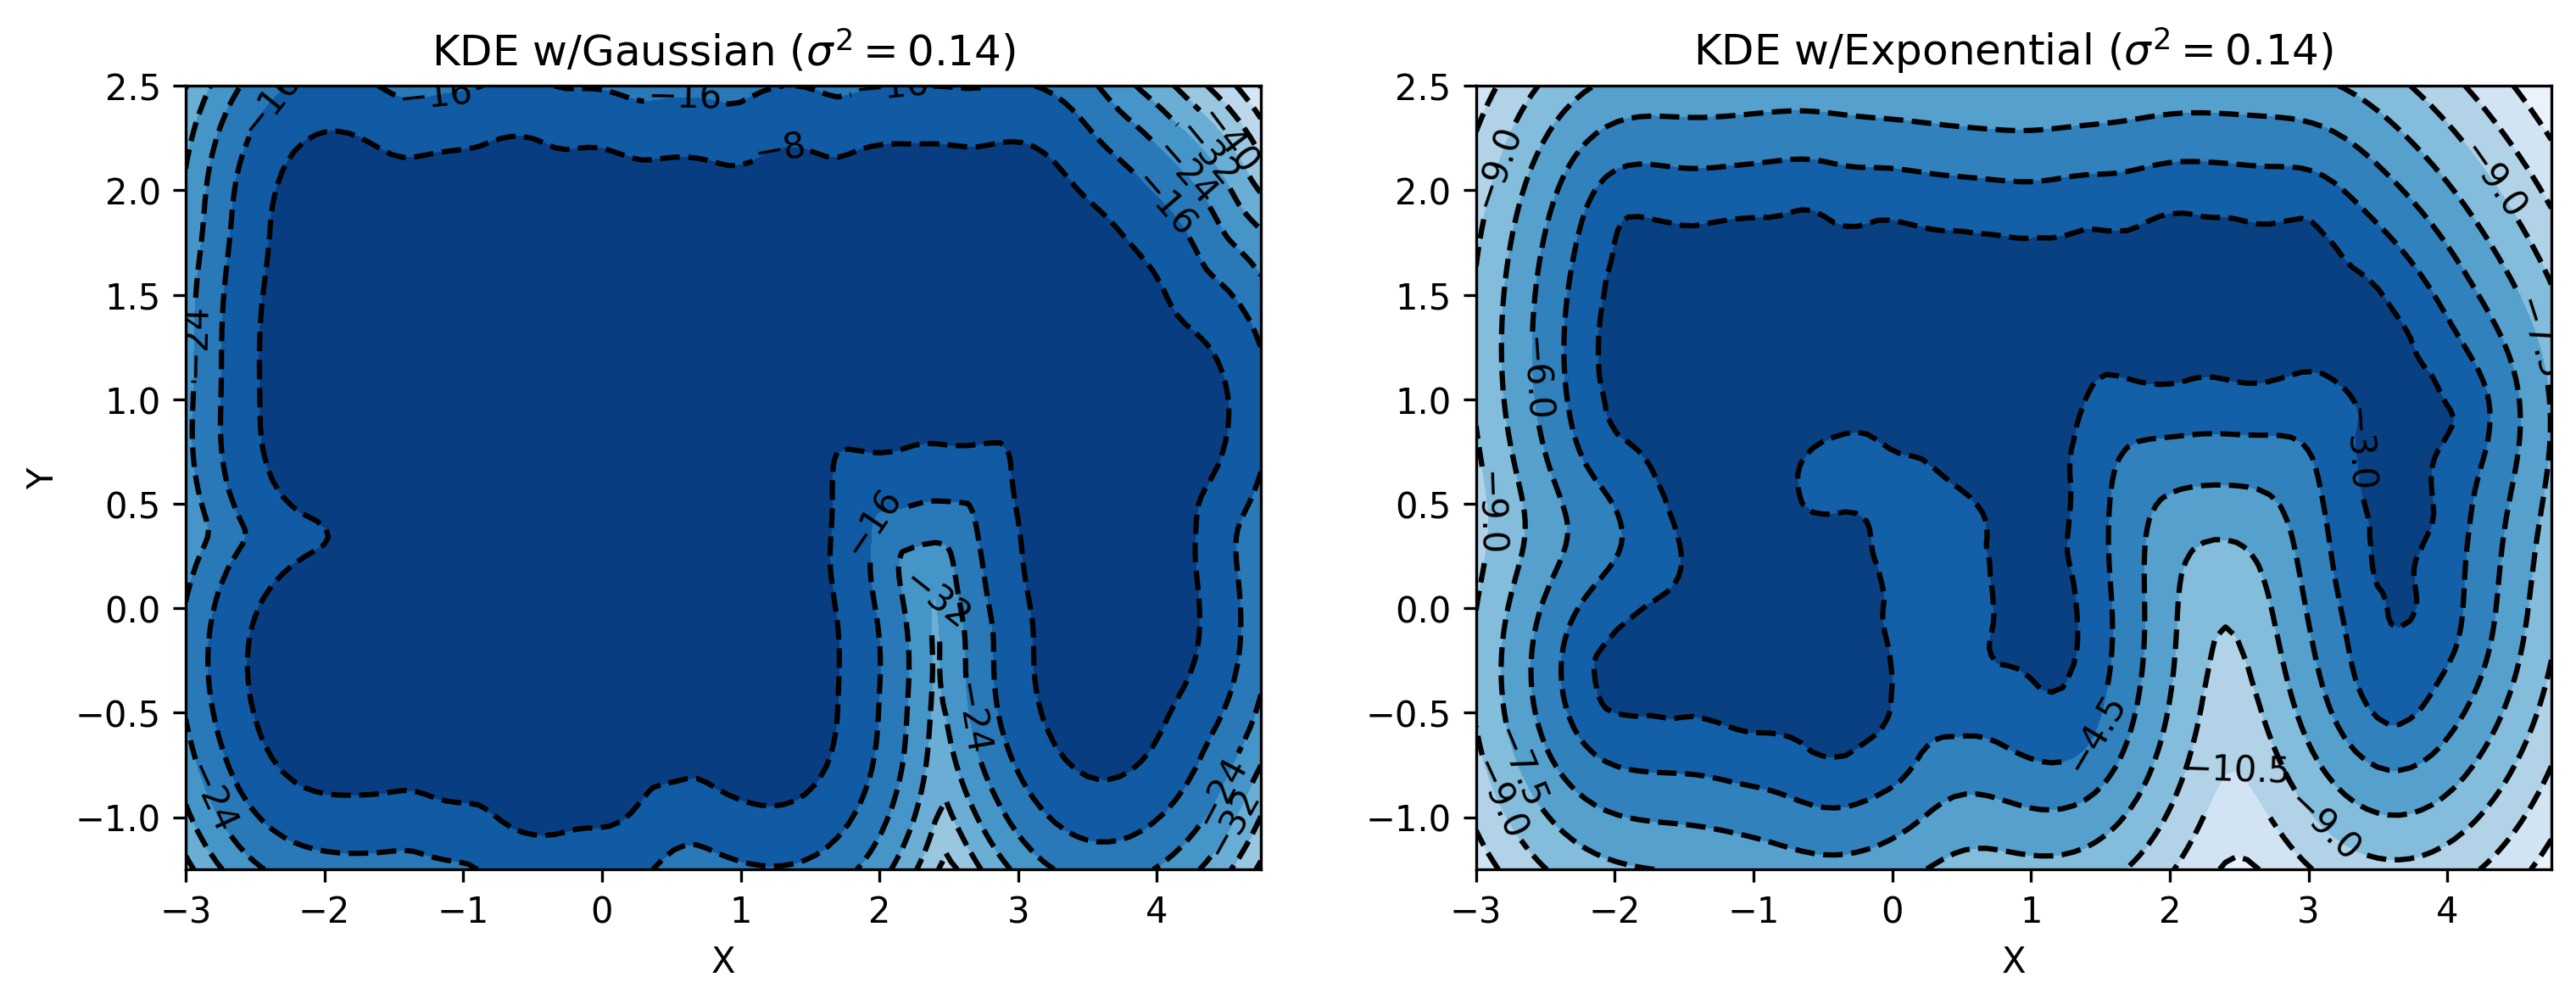

In [18]:
xmin, xmax = -3, 4.75
ymin, ymax = -1.25, 2.5

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()]).T


TARGET = np.array([[3.7, 0.0]])

BANDWIDTH = np.sqrt(0.02)

methods = ["gaussian", "exponential"]
fig, ax = plt.subplots(1, len(methods), figsize=(12, 4), dpi=300)

for idx, method in enumerate(methods):
    # Peform the kernel density estimate            
    kernel = KernelDensity(kernel=method, bandwidth=BANDWIDTH).fit(room_pos)

    kernel_val = np.reshape(kernel.score_samples(positions), xx.shape)
    
    ax[idx].set_xlim(xmin, xmax)
    ax[idx].set_ylim(ymin, ymax)
   
    # Contourf plot
    cfset = ax[idx].contourf(xx, yy, kernel_val, cmap="Blues")
    ## Or kernel density estimate plot instead of the contourf plot
    #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
    # Contour plot
    cset = ax[idx].contour(xx, yy, kernel_val, colors='k')
    ax[idx].clabel(cset, inline=1, fontsize=10)


    # Label plot
    ax[idx].set_xlabel('X')
    if idx == 0:
        ax[idx].set_ylabel('Y')
        
    ax[idx].set_title("KDE w/" + method.capitalize() + r" ($\sigma^2 = {:.2f}$)".format(BANDWIDTH))

plt.show()

In [19]:
kernel = KernelDensity(kernel=method, bandwidth=BANDWIDTH).fit(room_pos)
kernel_val = kernel.score_samples(positions)
bounds = [-3.4, -3]
indices = np.where((bounds[0]<=kernel_val) & (kernel_val<=bounds[1]))
boundry = positions[indices]
boundry.shape

(677, 2)

In [20]:
# Set Initial parameters
SCALE = 10
start = [-10, -2.5, np.deg2rad(90.0)]
goal = [36.5, 4, np.deg2rad(-90.0)]

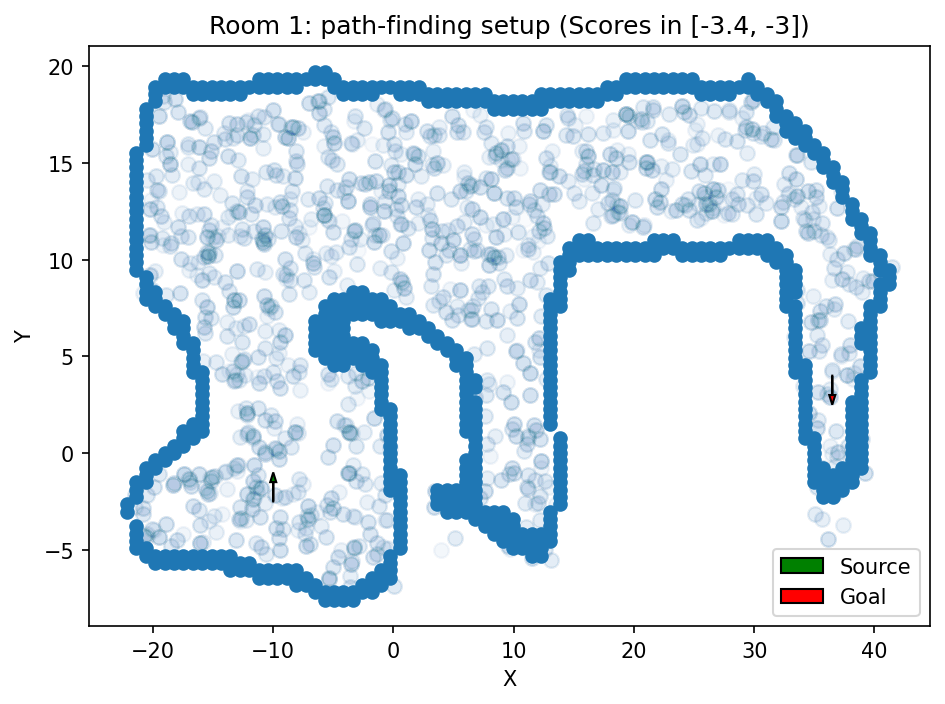

In [21]:
_ = plt.figure(dpi=150)
plt.scatter(room_pos[:,0]*SCALE, room_pos[:,1]*SCALE, color="tab:blue", s=50, alpha=.01)
plt.scatter(boundry[:,0]*SCALE, boundry[:,1]*SCALE, color="tab:blue")
rs.plot_arrow(start[0], start[1], start[2], fc='g', label="Source")
rs.plot_arrow(goal[0], goal[1], goal[2], label="Goal")
plt.title(f"Room {ROOM_NUM}: path-finding setup (Scores in [{bounds[0]}, {bounds[1]}])")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
cset.levels

array([-13.5, -12. , -10.5,  -9. ,  -7.5,  -6. ,  -4.5,  -3. ,  -1.5])

In [23]:
polys0 = cset.allsegs[-2]
x00, y00 = polys0[0].T
x00 *= SCALE
y00 *= SCALE

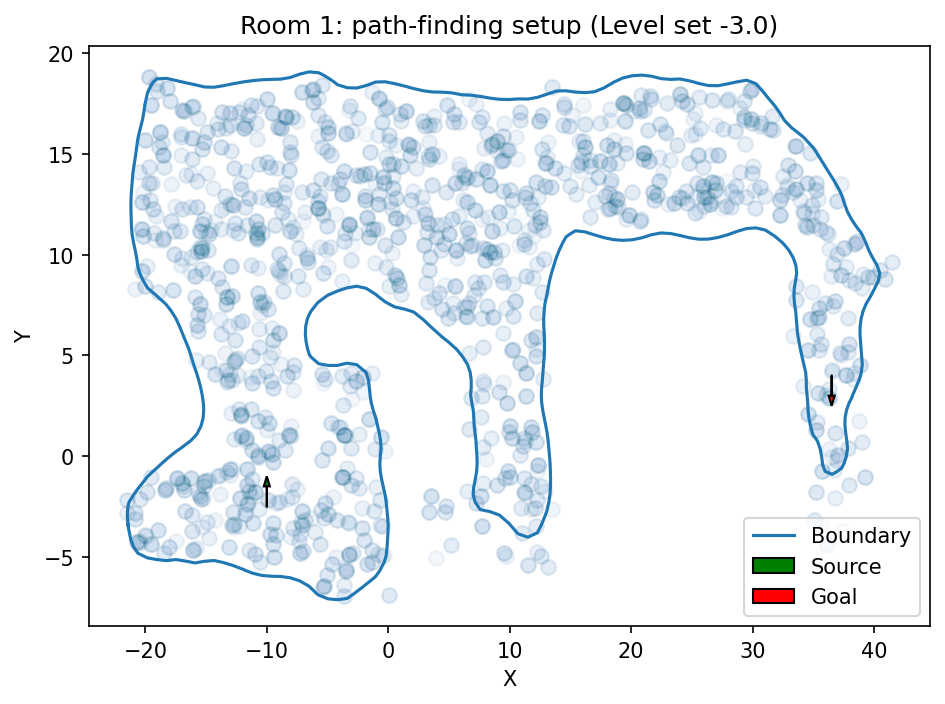

In [24]:
_ = plt.figure(dpi=150)
plt.scatter(room_pos[:,0]*SCALE, room_pos[:,1]*SCALE, color="tab:blue", s=50, alpha=.01)
plt.plot(x00, y00, color="tab:blue", label="Boundary")

rs.plot_arrow(start[0], start[1], start[2], fc='g', label="Source")
rs.plot_arrow(goal[0], goal[1], goal[2], label="Goal")
plt.title(f"Room {ROOM_NUM}: path-finding setup (Level set -3.0)")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
print("Start Hybrid A* planning")
print("start : ", start)
print("goal : ", goal)

path = hybrid_a_star_planning(start, goal,
                              x00.tolist(), y00.tolist(),
                              XY_GRID_RESOLUTION,
                              YAW_GRID_RESOLUTION)


Start Hybrid A* planning
start :  [-10, -2.5, 1.5707963267948966]
goal :  [36.5, 4, -1.5707963267948966]
path found


In [26]:
path_dict = {"x_list": path.x_list,
             "y_list": path.y_list,
             "yaw_list": path.yaw_list,
             "direction_list": path.direction_list,
             "cost": path.cost
             }

with open(f'room_{ROOM_NUM}_path.pickle', 'wb') as f:
    pickle.dump(path_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
with open(f'room_{ROOM_NUM}_path.pickle', 'rb') as f:
    path_dict = pickle.load(f)

In [28]:
x = path.x_list
y = path.y_list
yaw = path.yaw_list
images = []


if not os.path.exists(f"Figs/imgPathRoom{ROOM_NUM}/"):
     os.makedirs(f"Figs/imgPathRoom{ROOM_NUM}/")

for idx, (i_x, i_y, i_yaw) in enumerate(zip(x, y, yaw)):
    fig = plt.figure()
    plt.cla()
    plt.scatter(room_pos[:,0]*SCALE, room_pos[:,1]*SCALE, color="tab:blue", s=50, alpha=.01)
    plt.plot(x00, y00, color="tab:blue", label="Boundary")
    plt.plot(x, y, "-r", label="Path")
    plt.axis("equal")
    plot_car(i_x, i_y, i_yaw)
    plt.title(f"Room {ROOM_NUM}: Hybrid A* path")
    plt.legend()
    plt.tight_layout()
    fig.savefig(f"Figs/imgPathRoom{ROOM_NUM}/im{idx}.png", dpi=300)
    images.append(imageio.imread(f"Figs/imgPathRoom{ROOM_NUM}/im{idx}.png"))
    plt.close()
    

imageio.mimsave(f"Figs/pathRoom{ROOM_NUM}.gif", images)
